In [7]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate();
Pkg.add("PyPlot");
Pkg.add("ForwardDiff")

  Activating environment at `~/cmu_lectures/cmu_optimal_control_course/lecturenotes/lecture_notes/Lecture 2/Project.toml`
   Resolving package versions...
  No Changes to `~/cmu_lectures/cmu_optimal_control_course/lecturenotes/lecture_notes/Lecture 2/Project.toml`
  No Changes to `~/cmu_lectures/cmu_optimal_control_course/lecturenotes/lecture_notes/Lecture 2/Manifest.toml`
   Resolving package versions...
   Installed LogExpFunctions ─ v0.3.24
   Installed DiffRules ─────── v1.15.1
    Updating `~/cmu_lectures/cmu_optimal_control_course/lecturenotes/lecture_notes/Lecture 2/Project.toml`
  [f6369f11] + ForwardDiff v0.10.35
    Updating `~/cmu_lectures/cmu_optimal_control_course/lecturenotes/lecture_notes/Lecture 2/Manifest.toml`
  [d360d2e6] + ChainRulesCore v1.16.0
  [9e997f8a] + ChangesOfVariables v0.1.7
  [bbf7d656] + CommonSubexpressions v0.3.0
  [34da2185] + Compat v4.6.1
  [163ba53b] + DiffResults v1.1.0
  [b552c78f] + DiffRules v1.15.1
  [ffbed154] + DocStringExtensions v0.9.3
  

In [8]:
using LinearAlgebra
using PyPlot
using ForwardDiff

In [12]:
function pendulum_dynamics(x)
    l = 1.0
    g = 9.81
    
    θ = x[1]
    theta_dot =x[2]
    theta_ddot=-(g/l)*sin(θ)
    
    return [theta_dot,theta_ddot]
end

pendulum_dynamics (generic function with 1 method)

In [10]:
function pendulum_forward_euler(fun, x0, Tf, h)    
    t = Array(range(0,Tf,step=h))
    
    x_hist = zeros(length(x0),length(t))
    x_hist[:,1] .= x0
    
    for k = 1:(length(t)-1)
        x_hist[:,k+1] .= x_hist[:,k] + h*fun(x_hist[:,k])
    end
    
    return x_hist, t
end

pendulum_forward_euler (generic function with 1 method)

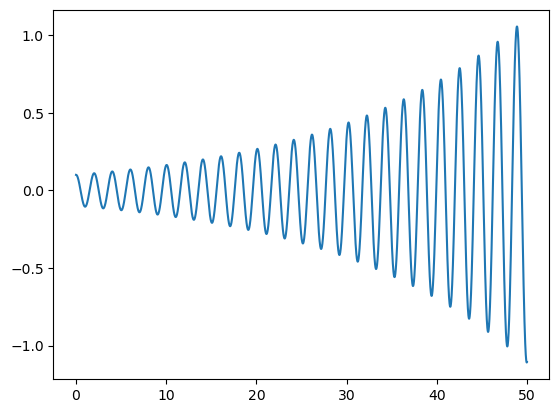

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f4c68947b80>

In [22]:
x0 = [.1; 0]
x_hist1, t_hist1 = pendulum_forward_euler(pendulum_dynamics, x0, 50, .01)
plot(t_hist1, x_hist1[1,:])

In [23]:
function pendulum_euler_Ad(x0, h)
    g = 9.81
    Ad = [1 h; -g*h*cos(x0[1]) 1]
end

pendulum_euler_Ad (generic function with 1 method)

In [24]:
eigvals(pendulum_euler_Ad(0, 0.001))

2-element Vector{ComplexF64}:
 1.0 - 0.0031320919526731652im
 1.0 + 0.0031320919526731652im

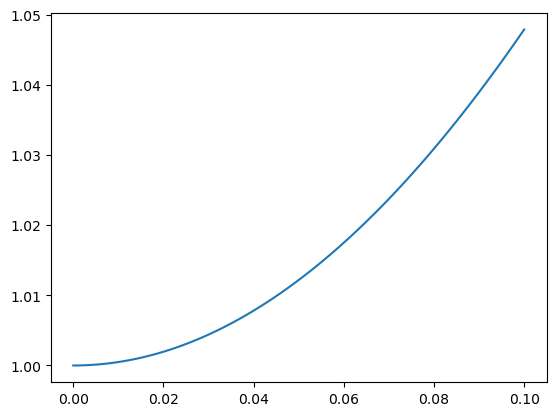

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f4c6891c3d0>

In [25]:
eignorm = zeros(100)
h = LinRange(0,0.1,100)
for k = 1:length(eignorm)
    eignorm[k] = max(norm.(eigvals(pendulum_euler_Ad([0;0], h[k])))...)
end
plot(h,eignorm)

In [26]:
function fd_pendulum_rk4(xk, h)
    f1 = pendulum_dynamics(xk)
    f2 = pendulum_dynamics(xk + 0.5*h*f1)
    f3 = pendulum_dynamics(xk + 0.5*h*f2)
    f4 = pendulum_dynamics(xk + h*f3)
    return xk + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
end

fd_pendulum_rk4 (generic function with 1 method)

In [27]:
function pendulum_rk4(fun, x0, Tf, h)    
    t = Array(range(0,Tf,step=h))
    
    x_hist = zeros(length(x0),length(t))
    x_hist[:,1] .= x0
    
    for k = 1:(length(t)-1)
        x_hist[:,k+1] .= fd_pendulum_rk4(x_hist[:,k], h)
    end
    
    return x_hist, t
end

pendulum_rk4 (generic function with 1 method)

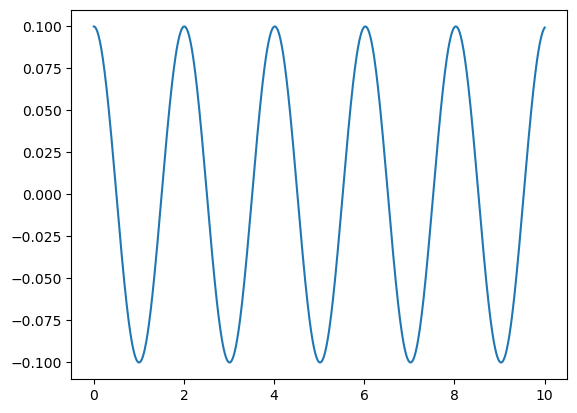

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f4c15eb7b50>

In [29]:
x0 = [.1; 0]
x_hist2, t_hist2 = pendulum_rk4(pendulum_dynamics, x0, 10, 0.01)
plot(t_hist2, x_hist2[1,:])

In [30]:
using ForwardDiff
Ad = ForwardDiff.jacobian(x -> fd_pendulum_rk4(x, 0.1), [0; 0])
norm.(eigvals(Ad))

2-element Vector{Float64}:
 0.999993524288704
 0.999993524288704

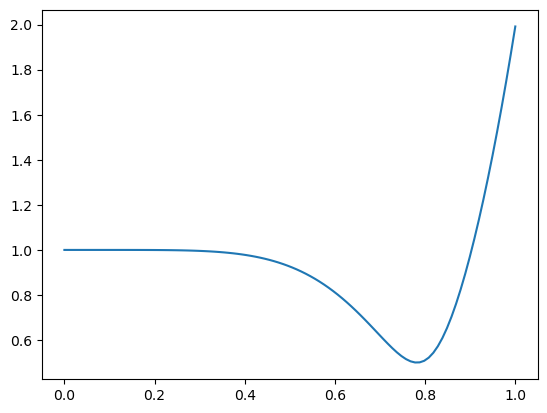

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f4c15e723d0>

In [31]:
eignorm = zeros(100)
h = LinRange(0,1,100)
for k = 1:length(eignorm)
    eignorm[k] = max(norm.(eigvals(ForwardDiff.jacobian(x -> fd_pendulum_rk4(x, h[k]), [0; 0])))...)
end
plot(h,eignorm)

In [32]:
function pendulum_backward_euler(fun, x0, Tf, dt)
    t = Array(range(0,Tf,step=dt))
    
    x_hist = zeros(length(x0),length(t))
    x_hist[:,1] .= x0
    
    for k = 1:(length(t)-1)
        e = 1
        x_hist[:,k+1] = x_hist[:,k]
        while e > 1e-8
            xn = x_hist[:,k] + dt.*fun(x_hist[:,k+1])
            e = norm(xn - x_hist[:,k+1])
            x_hist[:,k+1] .= xn
        end
    end
    
    return x_hist, t
end

pendulum_backward_euler (generic function with 1 method)

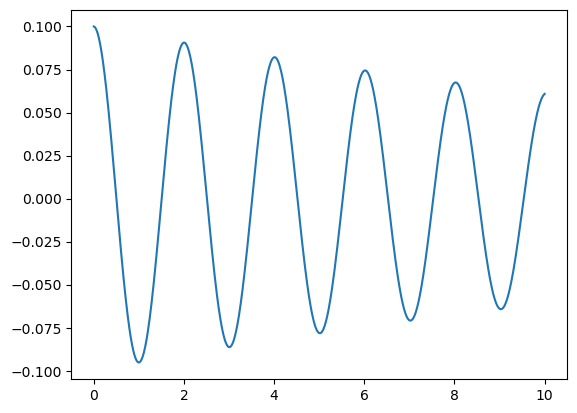

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f4c15dcb1c0>

In [33]:
x0 = [.1; 0]
x_hist3, t_hist3 = pendulum_backward_euler(pendulum_dynamics, x0, 10, 0.01)
plot(t_hist3, x_hist3[1,:])

LoadError: MethodError: no method matching pendulum_backward_euler(::Vector{Int64}, ::Float64)
[0mClosest candidates are:
[0m  pendulum_backward_euler(::Any, ::Any, [91m::Any[39m, [91m::Any[39m) at In[32]:1